# Подключение библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
import seaborn as sns
import math
import random
import time


from brian2 import NeuronGroup, Synapses, SpikeMonitor, StateMonitor
from brian2 import ms, mV
from brian2 import defaultclock, run, start_scope

In [2]:
from tsfresh.feature_extraction.settings import MinimalFCParameters, ComprehensiveFCParameters
from tsfresh import extract_features, select_features

In [72]:
from sklearn.ensemble import RandomForestClassifier as RandForest
from sklearn.ensemble import RandomForestRegressor as RandForestReg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import r2_score

# Класс Izhikevich_neurons

In [4]:
class Izhikevich_neurons :

    def __init__(self, neuron_number = 1000, excitatory_part = 0.5, record_time = 1000, window_size = 5,
                 exc_params = [0.02, 0.2, -65, 8], inh_params = [0.02, 0.25, -65, 2]) :
        self.Neuron_number = neuron_number
        self.Excitatory_part = excitatory_part
        self.Record_time = record_time
        self.Spike_activity_t = 0
        self.Spike_activity_i = 0
        self.Spike_numbers = 0
        self.Rate_data = 0
        self.Window_size = window_size
        self.Exc_params = exc_params
        self.Inh_params = inh_params

    def Init(self, neuron_number = 1000, excitatory_part = 0.5, record_time = 1000, window_size = 5,
             exc_params = [0.02, 0.2, -65, 8], inh_params = [0.02, 0.25, -65, 2]) :
        self.Neuron_number = neuron_number
        self.Excitatory_part = excitatory_part
        self.Record_time = record_time
        self.Spike_activity_t = 0
        self.Spike_activity_i = 0
        self.Spike_numbers = 0
        self.Rate_data = 0
        self.Window_size = window_size
        self.Exc_params = exc_params
        self.Inh_params = inh_params

    def Calculate_spike_activity(self, print_status_spike = False) :
        if print_status_spike :
            print("Calculating spike activity data")
        start_scope()
        tfinal = self.Record_time * ms
        Ne = int(self.Excitatory_part * self.Neuron_number)
        Ni = self.Neuron_number - Ne

        re = np.random.uniform(size=Ne)
        ri = np.random.uniform(size=Ni)
        weights = np.hstack(
            [
                0.5 * np.random.uniform(size=(Ne + Ni, Ne)),
                -np.random.uniform(size=(Ne + Ni, Ni)),
            ]
        ).T

        defaultclock.dt = 1 * ms

        eqs = """dv/dt = (0.04*v**2 + 5*v + 140 - u + I + I_noise )/ms : 1
                 du/dt = (a*(b*v - u))/ms  : 1
                 I : 1
                 I_noise : 1
                 a : 1
                 b : 1
                 c : 1
                 d : 1
               """

        N = NeuronGroup(Ne + Ni, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")
        N.v = -65

        N_exc = N[:Ne]
        N_inh = N[Ne:]

        spikemon = SpikeMonitor(N)
        statemon = StateMonitor(N, 'v', record=1, when='after_thresholds')
        N_exc.a = self.Exc_params[0]
        N_exc.b = self.Exc_params[1]
        N_exc.c = self.Exc_params[2] + 15 * re**2
        N_exc.d = self.Exc_params[3] - 6 * re**2

        N_inh.a = self.Inh_params[0] + 0.08 * ri
        N_inh.b = self.Inh_params[1] - 0.05 * ri
        N_inh.c = self.Inh_params[2]
        N_inh.d = self.Inh_params[3]
        #a = 0.1 тормозные
        #d = 4, c = -55 возб

        N_exc.u = "b*v"
        N_inh.u = "b*v"

        S = Synapses(
            N,
            N,
            "w : 1",
            on_pre={"up": "I += w", "down": "I -= w"},
            delay={"up": 0 * ms, "down": 1 * ms},
        )
        S.connect()
        S.w[:] = weights.flatten()

        N_exc.run_regularly("I_noise = 5*randn()", dt=1 * ms)
        N_inh.run_regularly("I_noise = 2*randn()", dt=1 * ms)

        run(tfinal)

        self.Spike_activity_t = spikemon.t/ms
        self.Spike_activity_i = spikemon.i[:]

    def Calculate_spike_numbers(self, print_status_activity = False) :
        if (self.Spike_activity_t == 0) :
            self.Calculate_spike_activity(print_status_spike = print_status_activity)
            if print_status_activity :
                print("Calculating spike numbers data")

        self.Spike_numbers = np.zeros([1, self.Record_time])
        start_t = (self.Spike_activity_t)[0]
        for index in range(len(self.Spike_activity_t)) :
            self.Spike_numbers[0, int(self.Spike_activity_t[index])] += 1

    def Calculate_rate_data(self, print_status_rate = False) :
        if (self.Spike_numbers == 0) :
            self.Calculate_spike_numbers(print_status_activity = print_status_rate)

        self.Rate_data = np.zeros([1, self.Record_time])
        for current_time in range(self.Record_time) :
            if print_status_rate :
                print(f'Current window size = {self.Window_size}')
                print(f'Current time : {current_time + 1} / {self.Record_time} ms')
            tmp_sum = 0
            i = current_time
            while (i < self.Record_time and i < current_time + self.Window_size) :
                tmp_sum += self.Spike_numbers[0, i]
                i += 1
            self.Rate_data[0, current_time] = tmp_sum
            if print_status_rate :
                clear_output(wait=True)

    def Plot_rate_data(self, Ax):
        Ax.set_xlabel("t/ms", fontsize = 30)
        Ax.set_ylabel("Rate data", fontsize = 30)
        Ax.set_title(f"Rate data (Window size = {self.Window_size}ms)\nExc_param = {self.Exc_params}\nInh_param = {self.Inh_params}", fontsize = 30)

        for label in (Ax.get_xticklabels() + Ax.get_yticklabels()):
            label.set_fontsize(25)

        Ax.plot([i + self.Spike_activity_t[0] for i in range(len(self.Spike_numbers))], self.Rate_data)


# Класс Dataset

Класс Dataset формирует набор данных

Параметры конструктора:
* $records\_number$ - число записей на выходе (или меньше, так как делается так, чтобы количество записей на каждый класс было одинаковым)
* $excitatory\_parts$ - список из чисел на отрезке $[0, 1]$. Каждое число задает долю возбуждающих нейронов в записи. Возможны два варианта:
    * Все элементы списка - числа. Тогда это и будут значения доли возбуждающих нейронов.
    * Первый элемент списка $excitaory\_parts == Random$ - тогда следующие два элемента задают интервал, на котором будут генерироваться случайные величины, а четвертый элемент задает количество классов. В этом случае доли возбуждающих нейронов будут получаться случайно на заданном интервале.
* $exc\_params$ - наборы параметров возбуждающих нейронов
* $inh\_params$ - наборы параметров тормозящих нейронов

In [5]:
class Dataset :
    def __init__(self, records_number = 100, excitatory_parts = [0.75], exc_params = [[0.02, 0.2, -65, 8]], inh_params = [[0.02, 0.25, -65, 2]], window_size = 1):
        if (excitatory_parts[0] == "Random") :
            self.Excitatory_parts = [excitatory_parts[1] + random.random() * (excitatory_parts[2] - excitatory_parts[1]) for i in range(excitatory_parts[3])]
        else :
            self.Excitatory_parts = excitatory_parts
        self.Class_number = len(self.Excitatory_parts) * len(exc_params) * len(inh_params)
        self.Records_number_per_class = int(records_number / self.Class_number) + int(records_number % self.Class_number > 0)
        self.Excitatory_params = exc_params
        self.Inhibitory_params = inh_params
        self.Window_size = window_size
        self.Rate_data = np.empty([0, 0])
        self.Classes = []

    def Make_rate_data(self, neuron_number = 1000, record_time = 1000):
        self.Rate_data = np.zeros([self.Class_number * self.Records_number_per_class, record_time])
        self.Classes = np.zeros([self.Class_number * self.Records_number_per_class, 9])
        Current_neuron_group = Izhikevich_neurons()
        class_index = 0
        start_time = time.time()
        for current_excitatory_part in self.Excitatory_parts :
            for current_excitatory_params in self.Excitatory_params :
                for current_inhibitory_params in self.Inhibitory_params :
                    class_index += 1
                    for current_record in range(1, self.Records_number_per_class + 1) :
                        print(f'Current class : {class_index} / {self.Class_number}')
                        print(f'Current record : {current_record} / {self.Records_number_per_class}')
                        time_left = (time.time() - start_time) * (self.Class_number - class_index - 1) / class_index
                        print(f'Time left : {int(time_left / 3600)} : {int((time_left % 3600) / 60)} : {int(time_left % 60)}')
                        Current_neuron_group.Init(window_size = self.Window_size,
                                                  excitatory_part = current_excitatory_part,
                                                  exc_params = current_excitatory_params,
                                                  inh_params = current_inhibitory_params,
                                                  neuron_number = neuron_number,
                                                  record_time = record_time)
                        Current_neuron_group.Calculate_rate_data()
                        self.Rate_data[(class_index - 1) * self.Records_number_per_class + current_record - 1, : ] = Current_neuron_group.Rate_data
                        self.Classes[(class_index - 1) * self.Records_number_per_class + current_record - 1, 0] = current_excitatory_part
                        self.Classes[(class_index - 1) * self.Records_number_per_class + current_record - 1, 1:5] = current_excitatory_params
                        self.Classes[(class_index - 1) * self.Records_number_per_class + current_record - 1, 5:9] = current_inhibitory_params
                        clear_output(wait=True)

# Класс Experiment

Класс $Experiment$ в конструкторе получает обучающую и тестовую выборки, а так-же методы, которые нужно использовать. Обучает все методы на данных и сохраняет результаты

In [73]:
class Experiment :
    def __init__(self, x_train, y_train, x_test, y_test, methods = [], methods_name = [], classification = True) :
        self.X_train = x_train
        self.X_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.Methods = methods
        self.Confusion_matrix = []
        self.Methods_name = methods_name
        self.Classification = classification
        self.Scores = []

    def Test(self, print_status = False) :
        self.Scores = pd.DataFrame(np.zeros(len(self.Methods)), index=self.Methods_name)
        for current_method in range(len(self.Methods)) :
            if print_status :
                print(f"Current method : {self.Methods_name[current_method]} ({current_method + 1} / {len(self.Methods)})")
            model = self.Methods[current_method]
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)
            if not self.Classification:
                self.Scores.iloc[current_method] = r2_score(self.y_test, y_pred)
            if self.Classification:
                self.Confusion_matrix.append(confusion_matrix(self.y_test, y_pred))

    def Plot_cunfusion_matrix(self) :
        w = min(len(self.Methods), 4)
        h = math.ceil(len(self.Methods) / w)
        fig, axes = plt.subplots(h, w, figsize = [4 * w, 4 * h - 1])
        plt.subplots_adjust(wspace=0.5, hspace=0.6)
        for current_method in range(len(self.Methods)) :
            if (h == 1) :
                if (w == 1) :
                    ax = axes
                else :
                    ax = axes[current_method % w]
            else :
                ax = axes[int(current_method / w), current_method % w]
            sns.heatmap(self.Confusion_matrix[current_method],
                        cmap='coolwarm_r',
                        linewidths=0.5,
                        annot=True,
                        ax=ax,
                        fmt="d")
            ax.set_title(f'{self.Methods_name[current_method]}', fontsize = 20)
            ax.set_ylabel('Real Classes', fontsize = 15)
            ax.set_xlabel('Predicted Classes', fontsize = 15)


# Тесты

## Пример данных активности

In [74]:
First_group = Izhikevich_neurons(window_size = 1, excitatory_part=0.75)
First_group.Calculate_rate_data(print_status_rate=True)

Second_group = Izhikevich_neurons(window_size = 1, excitatory_part=0.75, exc_params=[0.02, 0.2, -55, 4], inh_params=[0.1, 0.25, -65, 2])
Second_group.Calculate_rate_data(print_status_rate=True)

Current window size = 1
Current time : 1000 / 1000 ms


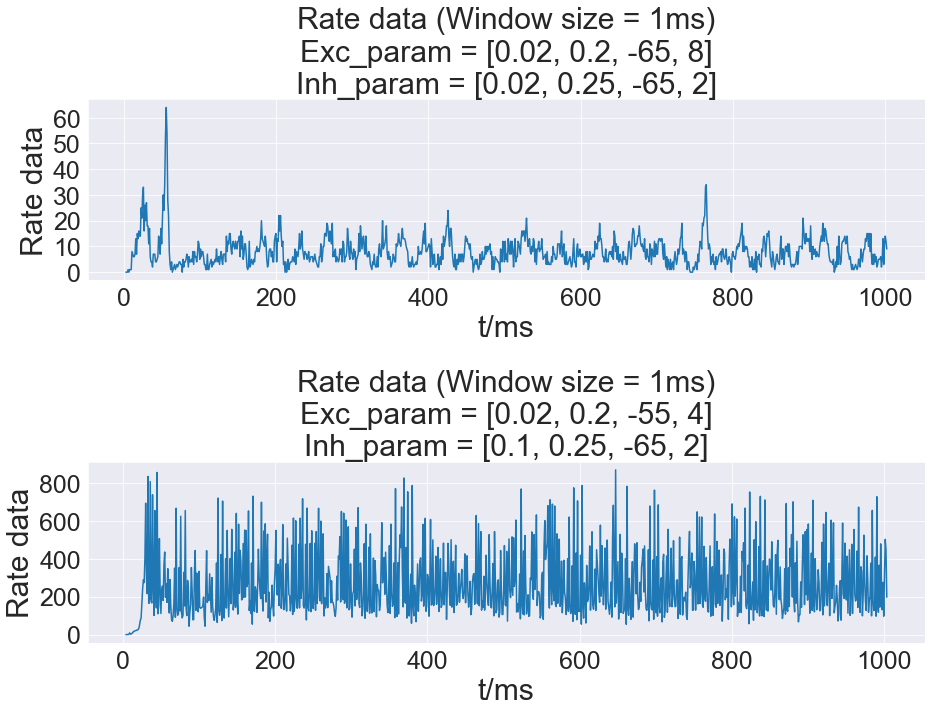

In [75]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize = [15, 10])
plt.subplots_adjust(hspace=1)
First_group.Plot_rate_data(ax1)
Second_group.Plot_rate_data(ax2)
plt.show()

## Получаем данные с параметрами $[Random, 0.5, 1, 250]$

In [ ]:
data = Dataset(excitatory_parts = ["Random", 0.5, 1, 250], records_number = 1000, exc_params=[[0.02, 0.2, -65, 8], [0.02, 0.2, -55, 4]], inh_params=[[0.02, 0.25, -65, 2], [0.1, 0.25, -65, 2]])
data.Make_rate_data()

In [110]:
np.savetxt("Rate_data.csv", data.Rate_data, delimiter = ',')
np.savetxt("Classes.csv", data.Classes, delimiter=',')

In [9]:
Classes = pd.read_csv('Classes.csv')
Classes

,6.322308942918641872e-01,2.000000000000000042e-02,2.000000000000000111e-01,-6.500000000000000000e+01,8.000000000000000000e+00,2.000000000000000042e-02.1,2.500000000000000000e-01,-6.500000000000000000e+01.1,2.000000000000000000e+00
0,0.632231,0.02,0.2,-65.0,8.0,0.10,0.25,-65.0,2.0
1,0.632231,0.02,0.2,-55.0,4.0,0.02,0.25,-65.0,2.0
2,0.632231,0.02,0.2,-55.0,4.0,0.10,0.25,-65.0,2.0
3,0.835232,0.02,0.2,-65.0,8.0,0.02,0.25,-65.0,2.0
4,0.835232,0.02,0.2,-65.0,8.0,0.10,0.25,-65.0,2.0
...,...,...,...,...,...,...,...,...,...
994,0.786999,0.02,0.2,-55.0,4.0,0.10,0.25,-65.0,2.0
995,0.572672,0.02,0.2,-65.0,8.0,0.02,0.25,-65.0,2.0
996,0.572672,0.02,0.2,-65.0,8.0,0.10,0.25,-65.0,2.0
997,0.572672,0.02,0.2,-55.0,4.0,0.02,0.25,-65.0,2.0


## Извлекаем признаки

In [10]:
Feature_data = pd.read_csv('Feature_data.csv')
Feature_data

,6.310000000000000000e+03,6.000000000000000000e+00,6.309999999999999609e+00,1.000000000000000000e+03,4.148722694999028349e+00,1.721189999999999998e+01,7.551688552899940454e+00,2.700000000000000000e+01,2.700000000000000000e+01.1,0.000000000000000000e+00
0,6363.0,6.0,6.363,1000.0,4.381921,19.201231,7.725866,34.0,34.0,0.0
1,378468.0,97.0,378.468,1000.0,356.013892,126745.890976,519.599767,851.0,851.0,0.0
2,303656.0,174.0,303.656,1000.0,275.294075,75786.827664,409.870460,909.0,909.0,0.0
3,271466.0,249.5,271.466,1000.0,174.348389,30397.360844,322.631601,870.0,870.0,0.0
4,278762.0,243.0,278.762,1000.0,184.668523,34102.463356,334.381094,911.0,911.0,0.0
...,...,...,...,...,...,...,...,...,...,...
994,296476.0,246.0,296.476,1000.0,162.069928,26266.661424,337.882642,875.0,875.0,0.0
995,5702.0,5.0,5.702,1000.0,3.595163,12.925196,6.740771,21.0,21.0,0.0
996,5591.0,5.0,5.591,1000.0,3.779381,14.283719,6.748555,24.0,24.0,0.0
997,469066.0,69.0,469.066,1000.0,429.204128,184216.183644,635.797999,928.0,928.0,0.0


In [198]:
start = time.time()
Feature_data  = pd.DataFrame()
Record_time = 1000
for current_class in range(data.Class_number) :
    for current_record in range(data.Records_number_per_class) :
        print(f'Current_class : {current_class + 1} / {data.Class_number}')
        print(f'Current record : {current_record + 1} / {data.Records_number_per_class}')
        time_left = (time.time() - start) * (data.Class_number - current_class - 1)  / (current_class + 1)
        print(f'Time left : {int(time_left / 3600)} : {int((time_left % 3600) / 60)} : {int(time_left % 60)}')
        Format_data_tmp = pd.DataFrame()
        Format_data_tmp['id'] = pd.Series([current_record] * Record_time)
        Format_data_tmp['time'] = pd.Series([i + 1 for i in range(Record_time)])
        Format_data_tmp['value'] = data.Rate_data[current_class]
        Feature_data = pd.concat([Feature_data,
                                  extract_features(Format_data_tmp,
                                                   column_id='id',
                                                   column_sort='time',
                                                   column_kind=None,
                                                   column_value='value',
                                                   default_fc_parameters=MinimalFCParameters(),
                                                   n_jobs = 10)])
        clear_output(wait=True)
Feature_data = Feature_data.to_numpy()
print("Ready")

Ready


## Обучаем модели

### Классификация на наборы параметров

In [ ]:
test_part = 0.3
test_indexes = int(test_part * len(Classes))
X_test = Feature_data.iloc[ : test_indexes]
X_train = Feature_data.iloc[test_indexes : ]

Classes_names = pd.DataFrame([[0, 0.02, 0.2, -65, 8, 0.02, 0.25, -65, 2],
                              [1, 0.02, 0.2, -65, 8, 0.1, 0.25, -65, 2],
                              [2, 0.02, 0.2, -55, 4, 0.02, 0.25, -65, 2],
                              [3, 0.02, 0.2, -55, 4, 0.1, 0.25, -65, 2]],
                             columns=["Class index",
                                      "Exc a", "Exc b", "Exc c", "Exc d",
                                      "Inh a", "Inh b", "Inh c", "Inh d"])

Y_test = np.zeros(test_indexes)
Y_train = np.zeros(len(Classes) - test_indexes)
for i in range(test_indexes) :
    print(i)
    for class_index in range(4) :
        if np.all(np.array(Classes.iloc[i][1:]) == np.array(Classes_names.iloc[class_index][1:])):
            Y_test[i] = class_index
for i in range(len(Classes) - test_indexes) :
    print(i)
    for class_index in range(4) :
        if np.all(np.array(Classes.iloc[i + test_indexes][1:]) == np.array(Classes_names.iloc[class_index][1:])):
            Y_train[i] = class_index

In [38]:
Classes_names

,Class index,Exc a,Exc b,Exc c,Exc d,Inh a,Inh b,Inh c,Inh d
0,0,0.02,0.2,-65,8,0.02,0.25,-65,2
1,1,0.02,0.2,-65,8,0.10,0.25,-65,2
2,2,0.02,0.2,-55,4,0.02,0.25,-65,2
3,3,0.02,0.2,-55,4,0.10,0.25,-65,2


In [56]:
A = Experiment(x_train = X_train,
               y_train = Y_train,
               x_test = X_test,
               y_test = Y_test,
               methods = [RandForest(10), RandForest(100), RandForest(1000)],
               methods_name = [f'RandForest(n = {10})', f'RandForest(n = {100})', f'RandForest(n = {1000})'])

In [57]:
A.Test(print_status = True)

Current method : RandForest(n = 10) (1 / 3)
Current method : RandForest(n = 100) (2 / 3)
Current method : RandForest(n = 1000) (3 / 3)


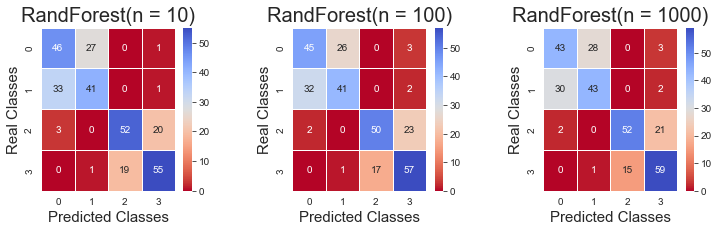

In [58]:
A.Plot_cunfusion_matrix()

### Задача регрессии на пропорцию

In [62]:
Y_test = np.array(Classes.iloc[ : test_indexes, 0])
Y_train = np.array(Classes.iloc[test_indexes : , 0])
Y_test

array([0.63223089, 0.63223089, 0.63223089, 0.83523238, 0.83523238,
       0.83523238, 0.83523238, 0.8131427 , 0.8131427 , 0.8131427 ,
       0.8131427 , 0.86636734, 0.86636734, 0.86636734, 0.86636734,
       0.65800482, 0.65800482, 0.65800482, 0.65800482, 0.91930927,
       0.91930927, 0.91930927, 0.91930927, 0.76200931, 0.76200931,
       0.76200931, 0.76200931, 0.52185731, 0.52185731, 0.52185731,
       0.52185731, 0.89727174, 0.89727174, 0.89727174, 0.89727174,
       0.6080431 , 0.6080431 , 0.6080431 , 0.6080431 , 0.95717944,
       0.95717944, 0.95717944, 0.95717944, 0.65886177, 0.65886177,
       0.65886177, 0.65886177, 0.70311485, 0.70311485, 0.70311485,
       0.70311485, 0.98274695, 0.98274695, 0.98274695, 0.98274695,
       0.96048435, 0.96048435, 0.96048435, 0.96048435, 0.78790752,
       0.78790752, 0.78790752, 0.78790752, 0.7324632 , 0.7324632 ,
       0.7324632 , 0.7324632 , 0.77205649, 0.77205649, 0.77205649,
       0.77205649, 0.67104502, 0.67104502, 0.67104502, 0.67104

In [74]:
A = Experiment(x_train = X_train,
               y_train = Y_train,
               x_test = X_test,
               y_test = Y_test,
               methods = [RandForestReg(n_estimators=10), RandForestReg(n_estimators=100), RandForestReg(n_estimators=1000)],
               methods_name = [f'RandForest(n = {10})', f'RandForest(n = {100})', f'RandForest(n = {1000})'],
               classification=False)

In [75]:
A.Test(print_status = True)

Current method : RandForest(n = 10) (1 / 3)
Current method : RandForest(n = 100) (2 / 3)
Current method : RandForest(n = 1000) (3 / 3)


In [76]:
A.Scores

,0
RandForest(n = 10),0.968961
RandForest(n = 100),0.969140
RandForest(n = 1000),0.970435
